In [1]:
import os
import tarfile
from six.moves import urllib

In [3]:
os.chdir('C:\\Users\miaox\Documents\handson-ml')

In [4]:
data_path = os.path.join('datasets','housing','housing.csv')

In [54]:
import pandas as pd
import numpy as np

# Exploratory data analysis

In [7]:
housing = pd.read_csv(data_path)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
#describe the numeric columns
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [10]:
# Print the value counts for categorical columns
for col in housing.columns:
    if housing[col].dtype=='object':
        print('\nColumn Name:', col,)
        print(housing[col].value_counts())


Column Name: ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64


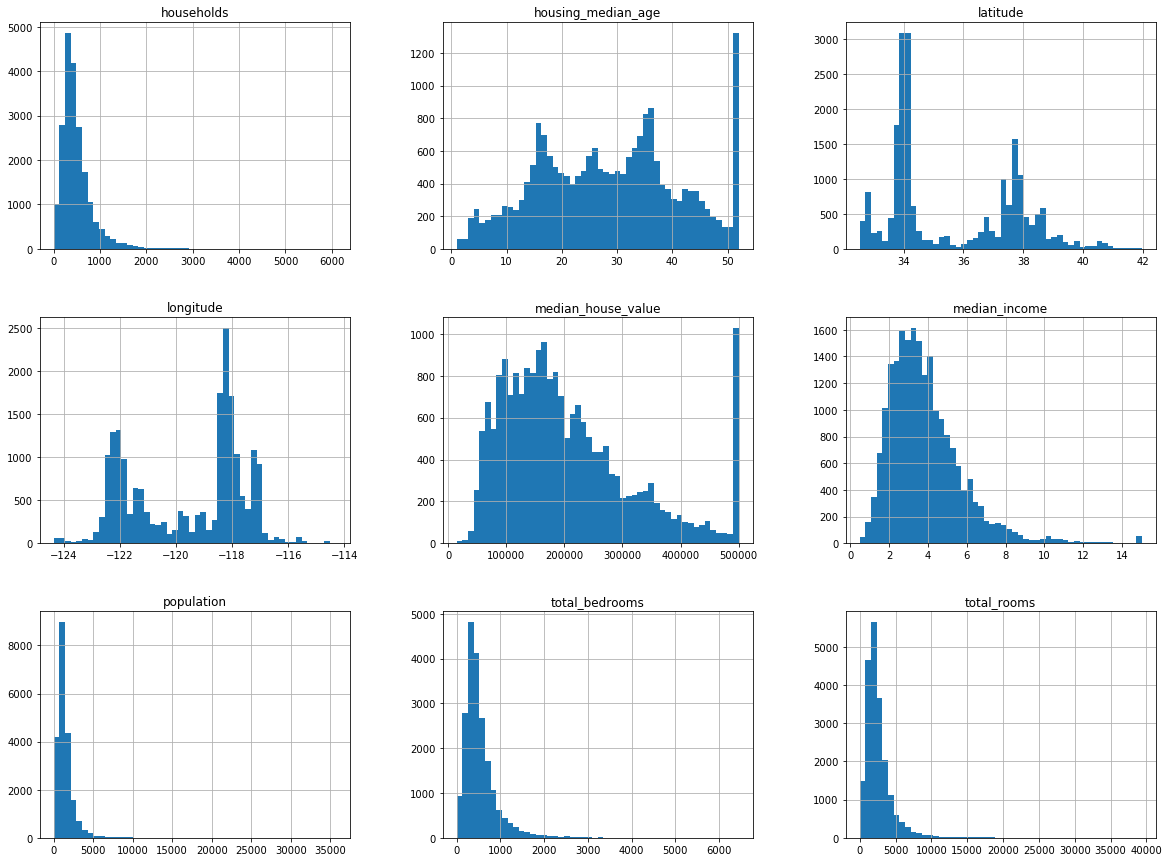

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

The main observations from the plot:
1. The median income attributes are not expressed in USD, they're scaled and capped at 15. The number represent roughly tens of thousands of dollar
2. The housing median age and median value also seem to be capped. The later is a bigger issue since that's your target. If client need precise prediction beyond 500K, we'll need to: 1) collect proper label for the ones capped 2) remove those district from training set since it will get poorly evaluated 
3. The histograms reveals the distribution are tail heavy, need to transform to bell shape later as some algorithm may have a hard time to detect these patterns.

In [14]:
#split data into train and valid
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, 
                                       random_state=42)

In [16]:
#create a copy of the data set so we can leave the train set untouhced
housing = train_set.copy()

No handles with labels found to put in legend.


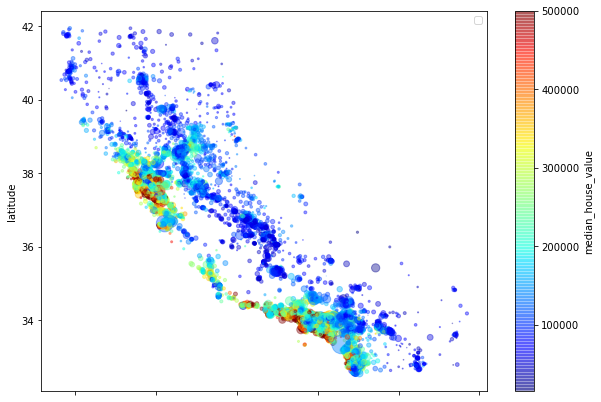

In [19]:
#Visualization
housing.plot(kind='scatter', x='longitude', y='latitude',alpha=0.4,
            s=housing['population']/100,figsize=(10,7),
            c='median_house_value',
            cmap=plt.get_cmap('jet'), colorbar=True)

plt.legend()

In [24]:
# run correlation
corr_matrix=housing.corr()
corr_matrix['median_house_value'].sort_values()

bedrooms_per_room          -0.257419
latitude                   -0.142983
longitude                  -0.046349
population                 -0.026032
population_per_household   -0.022030
total_bedrooms              0.047980
households                  0.063714
housing_median_age          0.103706
total_rooms                 0.133989
rooms_per_household         0.158485
median_income               0.690647
median_house_value          1.000000
Name: median_house_value, dtype: float64

In [23]:
# some basic feature engineering
housing['rooms_per_household']=housing['total_rooms']/housing['households']
housing['bedrooms_per_room']=housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household']=housing['population']/housing['households']

In [27]:
train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


# Prepare data for ML 

In [28]:
housing = train_set.drop('median_house_value', axis=1)
housing_labels = train_set['median_house_value'].copy()

## data cleaning

In [36]:
housing.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
ocean_proximity        object
dtype: object

In [37]:
# impute some missing value
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

# select only numeric variables for median impute
housing_num = housing.select_dtypes(include='float64')
imputer.fit(housing_num)

X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

In [44]:
#convert categorical variables to dummy variables
housing_cat = housing.select_dtypes(include='object')


from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [47]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [49]:
# Do the transformation on the data like we did earlier

from sklearn.base import BaseEstimator, TransformerMixin

rooms_iloc, bedrooms_iloc, population_iloc, households_iloc = 3,4,5,6


In [56]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room=add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_iloc]/X[:, households_iloc]
        population_per_household = X[:, population_iloc]/ X[:, households_iloc]
        if self.add_bedrooms_per_room:
            bedrooms_per_room=X[:, bedrooms_iloc] / X[:,rooms_iloc]
            return np.c_[X,rooms_per_household,population_per_household,
                        bedrooms_per_room]
        else:
            return np.c_[X,rooms_per_household,population_per_household]

In [57]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('attribs_adder',CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
                        ])

In [60]:
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [61]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])

In [62]:
housing_prepared = full_pipeline.fit_transform(housing)

# Select and Train a Model

In [64]:
# use linear regression as benchmark

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [66]:
# evaluate the model

from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
lin_rmse

In [68]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)
housing_predictions = tree_reg.predict(housing_prepared)
tree_rmse = np.sqrt(mean_squared_error(housing_labels, housing_predictions))
tree_rmse

0.0

In [71]:
# better to use cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring= 'neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([65214.1081309 , 70683.61402627, 68955.9319483 , 69037.69215536,
       74593.89139841, 67320.96887715, 66885.12246155, 67008.35682293,
       66874.37626811, 70476.04759059])

In [72]:
tree_rmse_scores.mean()

68705.01096795576

In [74]:
# try random forest

from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_rmse = np.sqrt((mean_squared_error(housing_labels, housing_predictions)))
forest_rmse

18539.47963476822

In [75]:
# cross validation
scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                        scoring ='neg_mean_squared_error', cv=10)
forest_rmse_score = np.sqrt(-scores)
forest_rmse_score.mean()

49775.903190533674

# Fine-tune the model

In [77]:
# grid search
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators':[3,10,30],
    'max_features':[2,4,6,8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap':[False],
    'n_estimators':[3,10],
    'max_features':[2,3,4]}
]

forest_reg = RandomForestRegressor()

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                          scoring = 'neg_mean_squared_error',
                          return_train_score =True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

get the best estimator

In [78]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [79]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63782.72908855181 {'max_features': 2, 'n_estimators': 3}
55063.22228106285 {'max_features': 2, 'n_estimators': 10}
52488.287610890635 {'max_features': 2, 'n_estimators': 30}
59453.43201978911 {'max_features': 4, 'n_estimators': 3}
52774.65671941747 {'max_features': 4, 'n_estimators': 10}
50248.29914500649 {'max_features': 4, 'n_estimators': 30}
58660.278925794075 {'max_features': 6, 'n_estimators': 3}
52295.923377882 {'max_features': 6, 'n_estimators': 10}
49759.54939917405 {'max_features': 6, 'n_estimators': 30}
58565.919707864945 {'max_features': 8, 'n_estimators': 3}
51998.482147153285 {'max_features': 8, 'n_estimators': 10}
49857.11311367401 {'max_features': 8, 'n_estimators': 30}
61708.43431096161 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53799.52662492473 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59539.15869136688 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52321.79906864224 {'bootstrap': False, 'max_features': 3, 'n_estimators': 

Evaluate the system on test set

In [81]:
final_model = grid_search.best_estimator_

X_test = test_set.drop('median_house_value', axis=1)
y_test = test_set['median_house_value'].copy()

X_test_prepared= full_pipeline.transform(X_test)

In [86]:
final_prediction = final_model.predict(X_test_prepared)
final_rmse = np.sqrt(mean_squared_error(y_test, final_prediction))
final_rmse

49212.55065682